In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, classification_report, 
confusion_matrix, precision_recall_curve, precision_score, recall_score, average_precision_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# plt.style.use('seaborn')
sns.set()

%matplotlib inline

In [2]:
df = pd.read_excel('pulsar_stars.xlsx')

In [3]:
#Fix the white space in front of all the column names (except for target_class)
clean_column_names = []

for name in df.columns:
    clean_name = name.lstrip()
    clean_column_names.append(clean_name)
    
df.columns = clean_column_names
df.columns

Index(['Mean of the integrated profile',
       'Standard deviation of the integrated profile',
       'Excess kurtosis of the integrated profile',
       'Skewness of the integrated profile', 'Mean of the DM-SNR curve',
       'Standard deviation of the DM-SNR curve',
       'Excess kurtosis of the DM-SNR curve', 'Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [4]:
#Separate the features from the target
X = df.drop('target_class', axis='columns')
y = df['target_class']

In [5]:
#Split regular data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
#Use MinMaxScaler on X_train and X_test
mmscaler = MinMaxScaler()
X_train_minmax = mmscaler.fit_transform(X_train)
X_test_minmax = mmscaler.transform(X_test)

In [7]:
#Use StandardScaler on X_train and X_test
standscaler = StandardScaler()
X_train_stand = standscaler.fit_transform(X_train)
X_test_stand = standscaler.transform(X_test)

In [91]:
#Define function for plotting ROC curves
def roc_plot_func(data, model_group):
    """Plot comparison of multiple ROC curves"""
    plt.figure(figsize = (13, 8))
    for item in data:
        fpr_min, tpr_min, thresholds = roc_curve(y_test, item[1].predict_proba(item[2])[:, 1])
        plt.plot(fpr_min, tpr_min, label=f"{item[0]}, AUROC = {round(item[3], 4)}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='orange') 

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curves for {model_group}", fontsize=15)

    plt.legend(fontsize=15)
    plt.savefig(f'{model_group}_roc_plot.png')
    plt.show()

In [117]:
#Define function for plotting PR-AUC curves
def pr_plot_func(data, model_group):
    """Plot comparison of multiple Precision-Recall curves"""
    plt.figure(figsize = (13, 8))
    for item in data:
        precision, recall, thresholds = precision_recall_curve(y_test, item[1].predict_proba(item[2])[:, 1])
        plt.plot(precision, recall, label=f"{item[0]}, PR-AUC = {round(item[4], 4)}")


    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(f"PR-AUC for {model_group}", fontsize=15)

    plt.legend(fontsize=15)
    plt.savefig(f'{model_group}_pr_plot.png')
    plt.show()

In [ ]:
def bar_chart_func(strings, pr_auc_scores, roc_auc_scores):
    """Creates bar chart comparing AUROC for PR-AUC for given classifier types"""
    label_loc = np.arange(len(strings))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(label_loc - width/2, pr_auc_scores, width, label='PR-AUC')
    rects2 = ax.bar(label_loc + width/2, roc_auc_scores, width, label='AUROC')

    ax.set_ylabel('Score')
    ax.set_title('Scores by AUROC and PR-AUC')
    ax.set_xticks(label_loc)
    ax.set_xticklabels(strings)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height"""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
        
    autolabel(rects1)
    autolabel(rects2)

    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=.0)
    plt.savefig(f'{strings[0]}_bar_chart.png')
    plt.show()

In [130]:
def bar_chart_func(strings, pr_auc_scores, roc_auc_scores):
    """Creates bar chart comparing AUROC for PR-AUC for given classifier types"""
    plt.figure(figsize = (13, 8))
    label_loc = np.arange(len(strings))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(label_loc - width/2, pr_auc_scores, width, label='PR-AUC')
    rects2 = ax.bar(label_loc + width/2, roc_auc_scores, width, label='AUROC')

    ax.set_ylabel('Score')
    ax.set_title('Scores by AUROC and PR-AUC', y=1.10)
    ax.set_xticks(label_loc)
    ax.set_xticklabels(strings)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height"""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
        
    autolabel(rects1)
    autolabel(rects2)

    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), borderaxespad=.0, loc='lower left',
              ncol=2, mode='expand')
    plt.savefig(f'{strings[0]}_bar_chart.png')
    plt.show()

# KNN

### KNN with GridSearch

In [11]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors' : np.arange(1, 15)}

knn_gscv = GridSearchCV(knn, param_grid, cv=5).fit(X_train, y_train)

In [12]:
knn_gscv_auroc = roc_auc_score(y_test, knn_gscv.predict_proba(X_test)[:, 1])
knn_gscv_pr_auc = average_precision_score(y_test, knn_gscv.predict_proba(X_test)[:, 1])

print(f"AUROC score: {knn_gscv_auroc}")
print(f"Best n_neighbors: {knn_gscv.best_params_.get('n_neighbors')}")
print(f"PR-AUC score: {knn_gscv_pr_auc}")
      

AUROC score: 0.9365052171926762
Best n_neighbors: 11
PR-AUC score: 0.8407457591402954


In [13]:
print(classification_report(y_test, knn_gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4049
           1       0.92      0.76      0.83       426

    accuracy                           0.97      4475
   macro avg       0.95      0.87      0.91      4475
weighted avg       0.97      0.97      0.97      4475



### Test using scaled data (MinMaxScaler and Standard Scaler)

#### MinMaxScaled data

In [14]:
param_grid = {'n_neighbors' : np.arange(1, 15)}

knn_gscv_minmax = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5).fit(X_train_minmax, y_train)

In [15]:
knn_gscv_minmax_auroc = roc_auc_score(y_test, knn_gscv_minmax.predict_proba(X_test_minmax)[:, 1])
knn_gscv_minmax_pr_auc = average_precision_score(y_test, knn_gscv_minmax.predict_proba(X_test_minmax)[:, 1])

print(f"AUROC score: {knn_gscv_minmax_auroc}")
print(f"Best n_neighbors: {knn_gscv_minmax.best_params_.get('n_neighbors')}")
print(f"PR-AUC score: {knn_gscv_minmax_pr_auc}")

AUROC score: 0.9399318442970326
Best n_neighbors: 9
PR-AUC score: 0.8681182914200458


In [16]:
print(classification_report(y_test, knn_gscv_minmax.predict(X_test_minmax)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.93      0.80      0.86       426

    accuracy                           0.98      4475
   macro avg       0.95      0.90      0.92      4475
weighted avg       0.97      0.98      0.97      4475



#### StandardScaled data

In [17]:
param_grid = {'n_neighbors' : np.arange(1, 15)}

knn_gscv_stand = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5).fit(X_train_stand, y_train)

In [18]:
knn_gscv_stand_auroc = roc_auc_score(y_test, knn_gscv_stand.predict_proba(X_test_stand)[:, 1])
knn_gscv_stand_pr_auc = average_precision_score(y_test, knn_gscv_stand.predict_proba(X_test_stand)[:, 1])

print(f"AUROC score: {knn_gscv_stand_auroc}")
print(f"Best n_neighbors: {knn_gscv_stand.best_params_.get('n_neighbors')}")
print(f"PR-AUC score: {knn_gscv_stand_pr_auc}")

AUROC score: 0.9437637183933435
Best n_neighbors: 14
PR-AUC score: 0.8730755006727098


In [19]:
print(classification_report(y_test, knn_gscv_stand.predict(X_test_stand)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.94      0.79      0.85       426

    accuracy                           0.97      4475
   macro avg       0.96      0.89      0.92      4475
weighted avg       0.97      0.97      0.97      4475



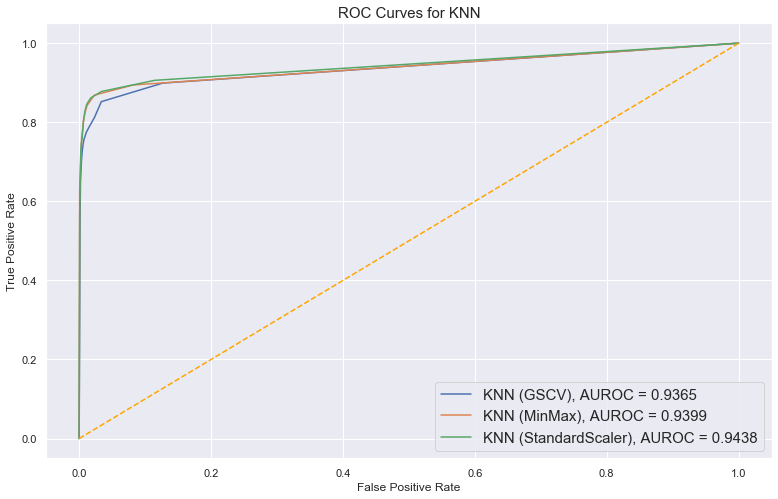

In [93]:
#zip together string of model names, models, x_test sets, and aurocs for plots
knn_names = ['KNN (GSCV)', 'KNN (MinMax)', 'KNN (StandardScaler)']
knn_models = [knn_gscv, knn_gscv_minmax, knn_gscv_stand]
knn_test_sets = [X_test, X_test_minmax, X_test_stand]
knn_aurocs = [knn_gscv_auroc, knn_gscv_minmax_auroc, knn_gscv_stand_auroc]
knn_pr_aucs = [knn_gscv_pr_auc, knn_gscv_minmax_pr_auc, knn_gscv_stand_pr_auc]

knn_info = zip(knn_names, knn_models, knn_test_sets, knn_aurocs)

roc_plot_func(knn_info, 'KNN')

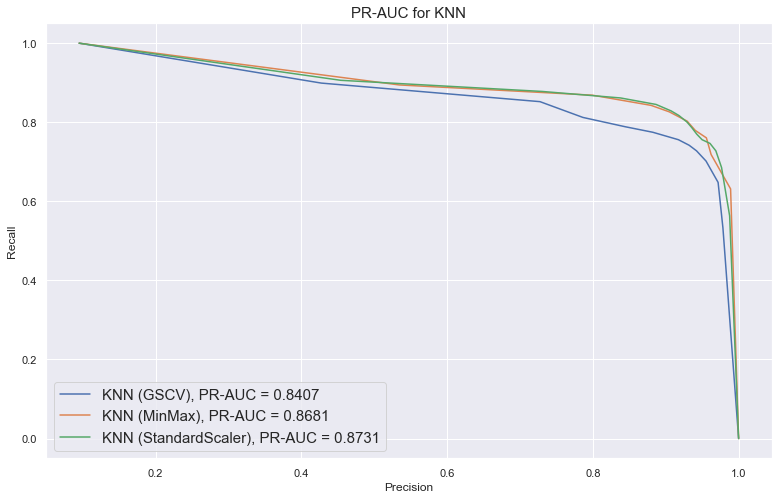

In [98]:
knn_info = zip(knn_names, knn_models, knn_test_sets, knn_aurocs, knn_pr_aucs)

pr_plot_func(knn_info, 'KNN')

<Figure size 936x576 with 0 Axes>

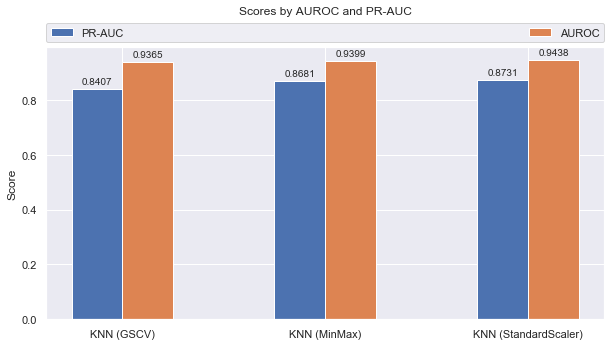

In [132]:
knn_pr_auc_scores_rounded = [round(x, 4) for x in knn_pr_aucs]
knn_roc_auc_scores_rounded = [round(x, 4) for x in knn_aurocs]


bar_chart_func(knn_names, knn_pr_auc_scores_rounded, knn_roc_auc_scores_rounded)

### KNN Result: Classifier with Standard scaled data has best AUROC and PR-AUC

# RBF SVM

### SVM with Grid Search

In [23]:
param_grid = {'C' : np.arange(12, 17), 'gamma' : np.logspace(-6, -6, 1)}

In [24]:
svm_gscv = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=3).fit(X_train, y_train)

In [25]:
svm_gscv_auroc = roc_auc_score(y_test, svm_gscv.predict_proba(X_test)[:, 1])
svm_gscv_pr_auc = average_precision_score(y_test, svm_gscv.predict_proba(X_test)[:, 1])

print(f"Best parameters: {svm_gscv.best_params_}")
print(f"AUROC score: {svm_gscv_auroc}")
print(f"PR-AUC score: {svm_gscv_pr_auc}")

Best parameters: {'C': 16, 'gamma': 1e-06}
AUROC score: 0.9553921040029589
PR-AUC score: 0.8773044330457517


In [26]:
print(classification_report(y_test, svm_gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4049
           1       0.92      0.72      0.81       426

    accuracy                           0.97      4475
   macro avg       0.95      0.86      0.90      4475
weighted avg       0.97      0.97      0.97      4475



### Test using scaled data (MinMaxScaler and Standard Scaler)

#### MinMaxScaled data

In [27]:
param_grid = {'C' : np.arange(4, 9), 'gamma' : np.arange(8, 13)}

svm_gscv_minmax = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=3).fit(X_train_minmax, y_train)

In [28]:
svm_gscv_minmax_auroc = roc_auc_score(y_test, svm_gscv_minmax.predict_proba(X_test_minmax)[:, 1])
svm_gscv_minmax_pr_auc = average_precision_score(y_test, svm_gscv_minmax.predict_proba(X_test_minmax)[:, 1])

print(f"AUROC score: {svm_gscv_minmax_auroc}")
print(f"Best parameters: {svm_gscv_minmax.best_params_}")
print(f"PR-AUC score: {svm_gscv_minmax_pr_auc}")

AUROC score: 0.937969961863881
Best parameters: {'C': 8, 'gamma': 12}
PR-AUC score: 0.8704984605917492


In [29]:
print(classification_report(y_test, svm_gscv_minmax.predict(X_test_minmax)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.93      0.81      0.87       426

    accuracy                           0.98      4475
   macro avg       0.96      0.90      0.93      4475
weighted avg       0.98      0.98      0.98      4475



#### StandardScaled data

In [30]:
param_grid = {'C' : np.arange(5, 16, 5), 'gamma' : np.logspace(-3, 0, 4)}

svm_gscv_stand = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=3).fit(X_train_stand, y_train)

In [31]:
svm_gscv_stand_auroc = roc_auc_score(y_test, svm_gscv_stand.predict_proba(X_test_stand)[:, 1])
svm_gscv_stand_pr_auc = average_precision_score(y_test, svm_gscv_stand.predict_proba(X_test_stand)[:, 1])

print(f"AUROC score: {svm_gscv_stand_auroc}")
print(f"Best parameters: {svm_gscv_stand.best_params_}")
print(f"PR-AUC score: {svm_gscv_stand_pr_auc}")

AUROC score: 0.9405011612442415
Best parameters: {'C': 15, 'gamma': 0.1}
PR-AUC score: 0.8785356702830316


In [32]:
print(classification_report(y_test, svm_gscv_stand.predict(X_test_stand)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.93      0.81      0.86       426

    accuracy                           0.98      4475
   macro avg       0.95      0.90      0.92      4475
weighted avg       0.97      0.98      0.97      4475



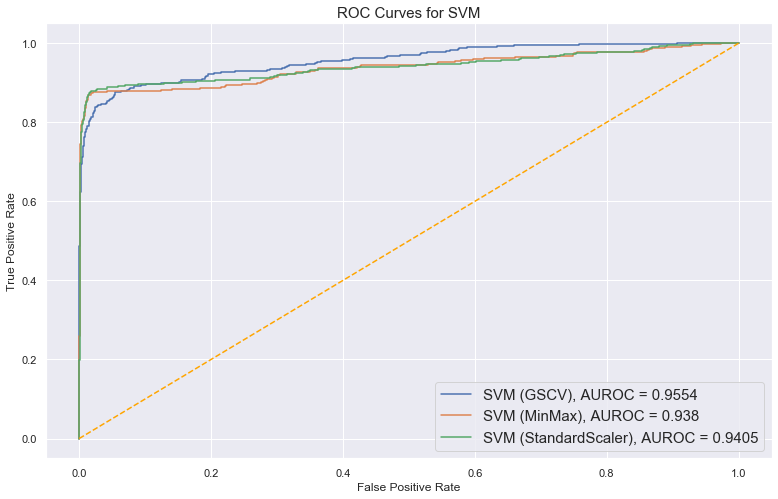

In [99]:
#zip together string of model names, models, x_test sets, and aurocs for plots
svm_names = ['SVM (GSCV)', 'SVM (MinMax)', 'SVM (StandardScaler)']
svm_models = [svm_gscv, svm_gscv_minmax, svm_gscv_stand]
svm_test_sets = [X_test, X_test_minmax, X_test_stand]
svm_aurocs = [svm_gscv_auroc, svm_gscv_minmax_auroc, svm_gscv_stand_auroc]
svm_pr_aucs = [svm_gscv_pr_auc, svm_gscv_minmax_pr_auc, svm_gscv_stand_pr_auc]
              
svm_info = zip(svm_names, svm_models, svm_test_sets, svm_aurocs, svm_pr_aucs)

roc_plot_func(svm_info, 'SVM')

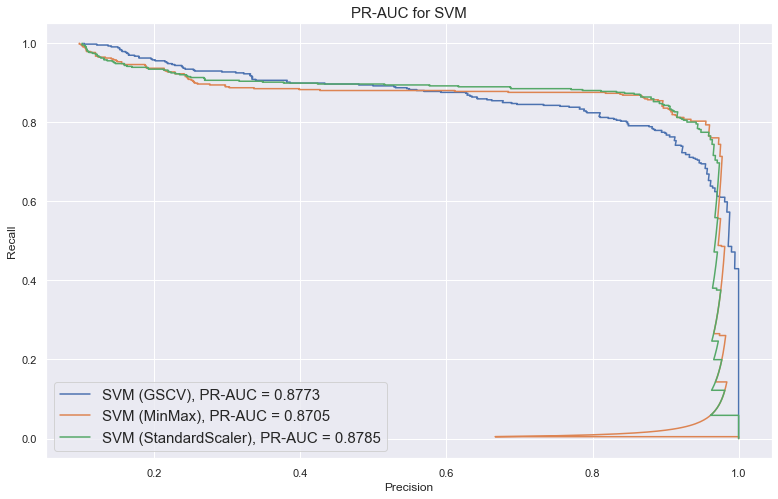

In [100]:
svm_info = zip(svm_names, svm_models, svm_test_sets, svm_aurocs, svm_pr_aucs)

pr_plot_func(svm_info, 'SVM')

<Figure size 936x576 with 0 Axes>

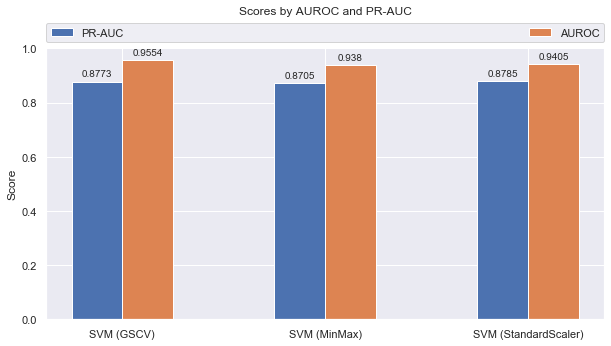

In [133]:
svm_pr_aucs_rounded = [round(x, 4) for x in svm_pr_aucs]
svm_aurocs_rounded = [round(x, 4) for x in svm_aurocs]

bar_chart_func(svm_names, svm_pr_aucs_rounded, svm_aurocs_rounded)

### SVM Result: SVM(GSCV) has highest AUROC and PR-AUC

# Logistic Regression

In [36]:
logreg = LogisticRegression().fit(X_train, y_train)

In [37]:
logreg_auroc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
logreg_pr_auc = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])

print(f"AUROC score: {logreg_auroc}")
print(f"PR-AUC score: {logreg_pr_auc}")

AUROC score: 0.965033387946018
PR-AUC score: 0.906061254650831


In [38]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.93      0.80      0.86       426

    accuracy                           0.98      4475
   macro avg       0.96      0.89      0.92      4475
weighted avg       0.97      0.98      0.97      4475



### LogReg with Grid Search

In [39]:
param_grid = {'C' : [1, 10, 20]}

logreg_gscv = GridSearchCV(LogisticRegression(), param_grid=param_grid).fit(X_train, y_train)

In [40]:
logreg_gscv_auroc = roc_auc_score(y_test, logreg_gscv.predict_proba(X_test)[:, 1])
logreg_gscv_pr_auc = average_precision_score(y_test, logreg_gscv.predict_proba(X_test)[:, 1])

print(f"AUROC score: {logreg_gscv_auroc}")
print(f"Best parameters: {logreg_gscv.best_params_}")
print(f"PR-AUC score: {logreg_gscv_pr_auc}")

AUROC score: 0.9651557157218441
Best parameters: {'C': 10}
PR-AUC score: 0.9063509805077262


In [41]:
print(classification_report(y_test, logreg_gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.93      0.80      0.86       426

    accuracy                           0.98      4475
   macro avg       0.96      0.90      0.92      4475
weighted avg       0.97      0.98      0.97      4475



### Test using scaled data (MinMaxScaler and Standard Scaler)

#### MinMaxScaled data

In [42]:
param_grid = {'C' : np.logspace(2, 3, 4)}

logreg_gscv_minmax = GridSearchCV(LogisticRegression(), param_grid=param_grid).fit(X_train_minmax, y_train)


In [43]:
logreg_gscv_minmax_auroc = roc_auc_score(y_test, logreg_gscv_minmax.predict_proba(X_test_minmax)[:, 1])
logreg_gscv_minmax_pr_auc = average_precision_score(y_test, logreg_gscv_minmax.predict_proba(X_test_minmax)[:, 1])

print(f"AUROC score: {logreg_gscv_minmax_auroc}")
print(f"Best parameters: {logreg_gscv_minmax.best_params_}")
print(f"PR-AUC score: {logreg_gscv_minmax_pr_auc}")

AUROC score: 0.966654955666327
Best parameters: {'C': 464.15888336127773}
PR-AUC score: 0.9121614338461314


In [44]:
print(classification_report(y_test, logreg_gscv_minmax.predict(X_test_minmax)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.94      0.80      0.86       426

    accuracy                           0.98      4475
   macro avg       0.96      0.90      0.92      4475
weighted avg       0.98      0.98      0.97      4475



#### StandardScaled data

In [45]:
param_grid = {'C' : np.logspace(0, 2, 3)}

logreg_gscv_stand = GridSearchCV(LogisticRegression(), param_grid=param_grid).fit(X_train_stand, y_train)


In [46]:
logreg_gscv_stand_auroc = roc_auc_score(y_test, logreg_gscv_stand.predict_proba(X_test_stand)[:, 1])
logreg_gscv_stand_pr_auc = average_precision_score(y_test, logreg_gscv_stand.predict_proba(X_test_stand)[:, 1])

print(f"AUROC score: {logreg_gscv_stand_auroc}")
print(f"Best parameters: {logreg_gscv_stand.best_params_}")
print(f"PR-AUC score: {logreg_gscv_stand_pr_auc}")

AUROC score: 0.9666682899736443
Best parameters: {'C': 10.0}
PR-AUC score: 0.9122225387307469


In [47]:
print(classification_report(y_test, logreg_gscv_stand.predict(X_test_stand)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.94      0.80      0.86       426

    accuracy                           0.98      4475
   macro avg       0.96      0.90      0.92      4475
weighted avg       0.98      0.98      0.97      4475



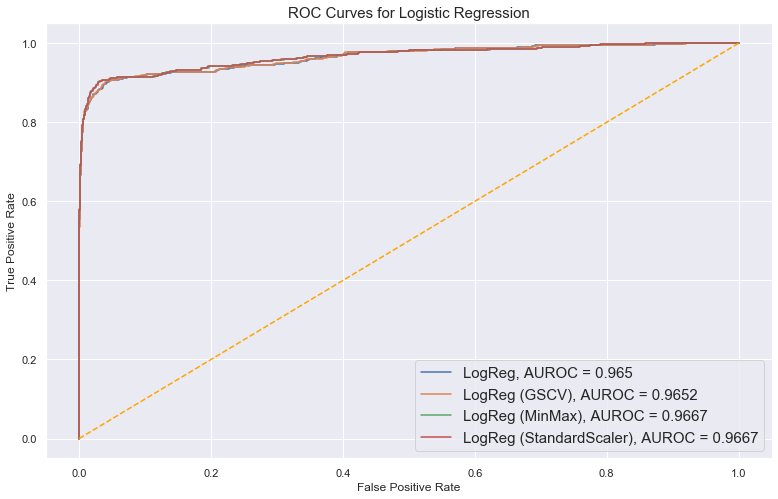

In [102]:
#zip together string of model names, models, x_test sets, and aurocs for plots
logreg_names = ['LogReg', 'LogReg (GSCV)', 'LogReg (MinMax)', 'LogReg (StandardScaler)']
logreg_models = [logreg, logreg_gscv, logreg_gscv_minmax, logreg_gscv_stand]
logreg_test_sets = [X_test, X_test, X_test_minmax, X_test_stand]
logreg_aurocs = [logreg_auroc, logreg_gscv_auroc, logreg_gscv_minmax_auroc, logreg_gscv_stand_auroc]
logreg_pr_aucs = [logreg_pr_auc, logreg_gscv_pr_auc, logreg_gscv_minmax_pr_auc, logreg_gscv_stand_pr_auc]
              
logreg_info = zip(logreg_names, logreg_models, logreg_test_sets, logreg_aurocs, logreg_pr_aucs)

roc_plot_func(logreg_info, 'Logistic Regression')

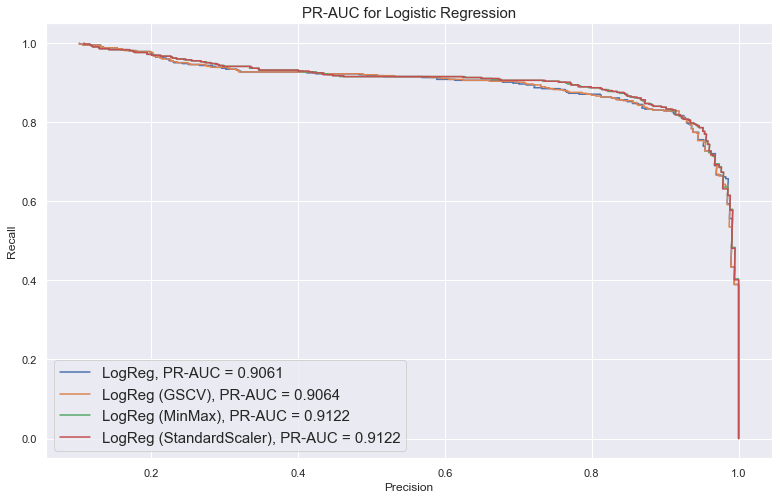

In [103]:
logreg_info = zip(logreg_names, logreg_models, logreg_test_sets, logreg_aurocs, logreg_pr_aucs)

pr_plot_func(logreg_info, 'Logistic Regression')

<Figure size 936x576 with 0 Axes>

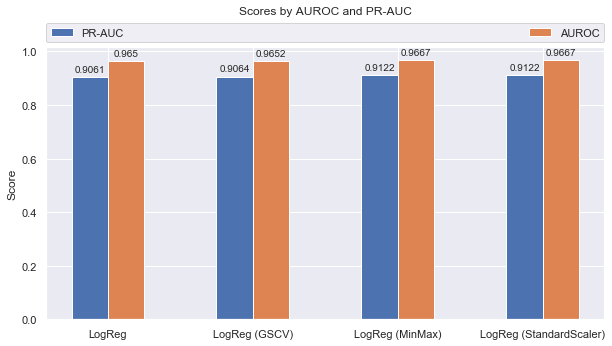

In [134]:
logreg_pr_aucs_rounded = [round(x, 4) for x in logreg_pr_aucs]
logreg_aurocs_rounded = [round(x, 4) for x in logreg_aurocs]

bar_chart_func(logreg_names, logreg_pr_aucs_rounded, logreg_aurocs_rounded)

### Log Reg Result: Basically a tie across the board, choose LogReg (MinMax)

# Random Forest

In [51]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [52]:
rf_auroc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
rf_pr_auc = average_precision_score(y_test, rf.predict(X_test))

print(f"AUROC score: {rf_auroc}")
print(f"PR-AUC score: {rf_pr_auc}")

AUROC score: 0.9620569386517508
PR-AUC score: 0.7717304461185014


In [53]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.92      0.82      0.87       426

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



### Random Forest with Grid Search

In [54]:
param_grid = {
    'n_estimators' : np.arange(10, 500, 50),
    'max_depth' : [10, 20, 30]
}

rf_gscv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid).fit(X_train, y_train)

In [55]:
rf_gscv_auroc = roc_auc_score(y_test, rf_gscv.predict_proba(X_test)[:, 1])
rf_gscv_pr_auc = average_precision_score(y_test, rf_gscv.predict(X_test))

print(f"AUROC score: {rf_gscv_auroc}")
print(f"Best parameters: {rf_gscv.best_params_}")
print(f"PR-AUC score: {rf_gscv_pr_auc}")

AUROC score: 0.9672294903859644
Best parameters: {'max_depth': 10, 'n_estimators': 260}
PR-AUC score: 0.7694981309333343


In [56]:
print(classification_report(y_test, rf_gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.92      0.82      0.87       426

    accuracy                           0.98      4475
   macro avg       0.95      0.90      0.93      4475
weighted avg       0.98      0.98      0.98      4475



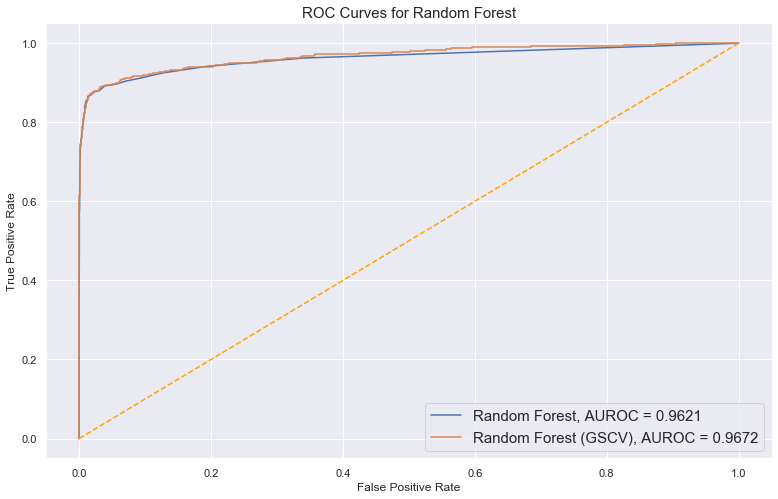

In [105]:
#zip together string of model names, models, x_test sets, and aurocs for plots
rf_names = ['Random Forest', 'Random Forest (GSCV)']
rf_models = [rf, rf_gscv]
rf_test_sets = [X_test, X_test]
rf_aurocs = [rf_auroc, rf_gscv_auroc]
rf_pr_aucs = [rf_pr_auc, rf_gscv_pr_auc]
              
rf_info = zip(rf_names, rf_models, rf_test_sets, rf_aurocs, rf_pr_aucs)

roc_plot_func(rf_info, 'Random Forest')

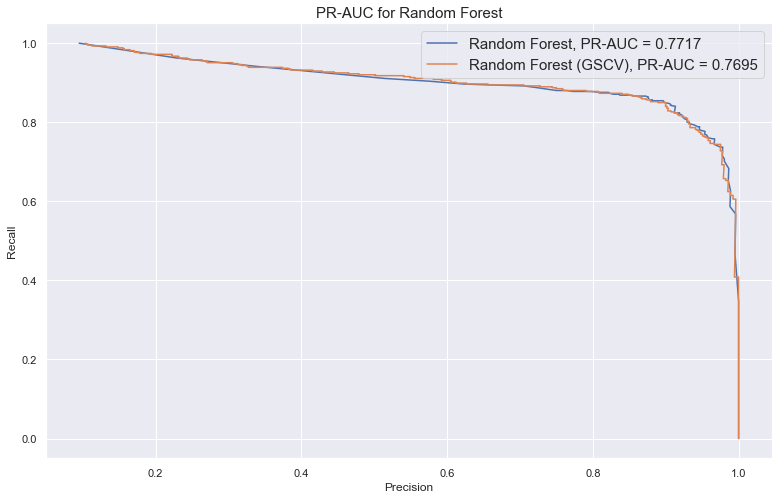

In [106]:
rf_info = zip(rf_names, rf_models, rf_test_sets, rf_aurocs, rf_pr_aucs)

pr_plot_func(rf_info, 'Random Forest')

<Figure size 936x576 with 0 Axes>

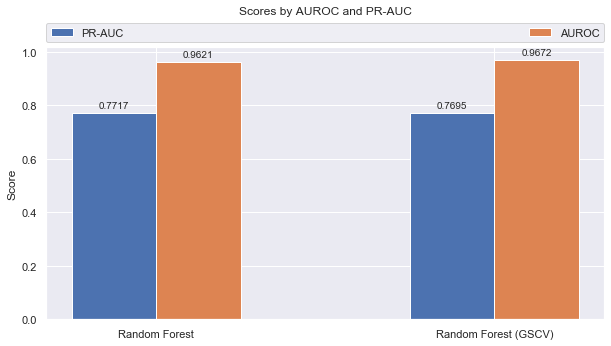

In [135]:
rf_pr_aucs_rounded = [round(x, 4) for x in rf_pr_aucs]
rf_aurocs_rounded = [round(x, 4) for x in rf_aurocs]

bar_chart_func(rf_names, rf_pr_aucs_rounded, rf_aurocs_rounded)

# Gradient Boosting Classifier

In [60]:
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [61]:
gb_auroc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
gb_pr_auc = average_precision_score(y_test, gb.predict_proba(X_test)[:, 1])
print()

print(f"AUROC score: {gb_auroc}")
print(f"PR-AUC score: {gb_pr_auc}")


AUROC score: 0.9684672619565255
PR-AUC score: 0.8581071190247345


In [62]:
print(classification_report(y_test, gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4049
           1       0.90      0.81      0.85       426

    accuracy                           0.97      4475
   macro avg       0.94      0.90      0.92      4475
weighted avg       0.97      0.97      0.97      4475



### Gradient Boosting with Grid Search

In [63]:
param_grid = {'learning_rate' : [.0001, .001, .01, .1], 'n_estimators' : [250, 300, 350, 400]}

gb_gscv = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid).fit(X_train, y_train)

In [64]:
gb_gscv_auroc = roc_auc_score(y_test, gb_gscv.predict_proba(X_test)[:, 1])
gb_gscv_pr_auc = average_precision_score(y_test, gb_gscv.predict_proba(X_test)[:, 1])


print(f"AUROC: {gb_gscv_auroc}")
print(f"Best parameters: {gb_gscv.best_params_}")
print(f"PR-AUC score: {gb_pr_auc}")

AUROC: 0.9664801602899691
Best parameters: {'learning_rate': 0.01, 'n_estimators': 250}
PR-AUC score: 0.8581071190247345


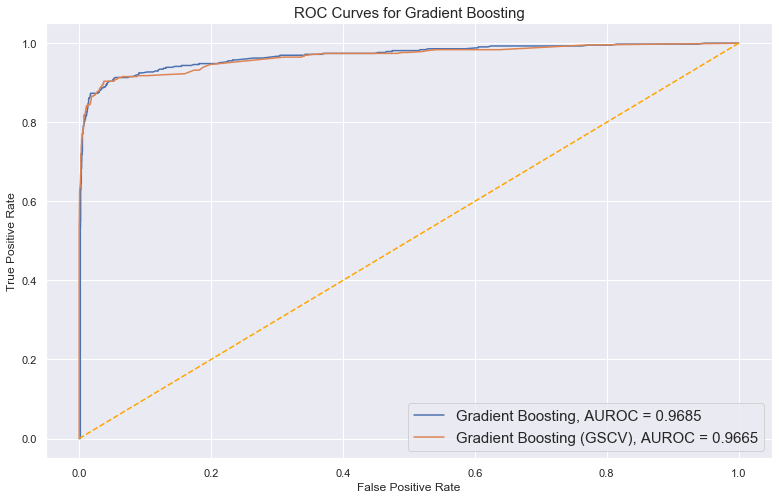

In [108]:
#zip together string of model names, models, x_test sets, and aurocs for plots
gb_names = ['Gradient Boosting', 'Gradient Boosting (GSCV)']
gb_models = [gb, gb_gscv]
gb_test_sets = [X_test, X_test]
gb_aurocs = [gb_auroc, gb_gscv_auroc]
gb_pr_aucs = [gb_pr_auc, gb_gscv_pr_auc]
              
gb_info = zip(gb_names, gb_models, gb_test_sets, gb_aurocs, gb_pr_aucs)

roc_plot_func(gb_info, 'Gradient Boosting')

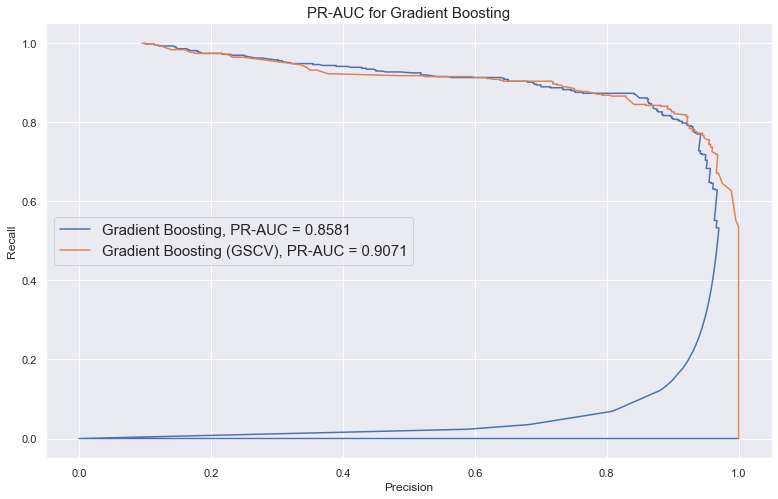

In [109]:
gb_info = zip(gb_names, gb_models, gb_test_sets, gb_aurocs, gb_pr_aucs)


pr_plot_func(gb_info, 'Gradient Boosting')

<Figure size 936x576 with 0 Axes>

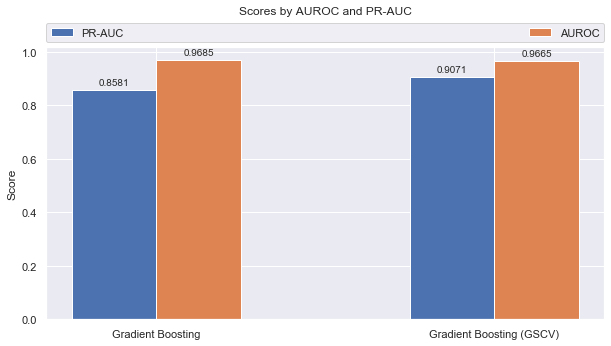

In [136]:
gb_pr_aucs_rounded = [round(x, 4) for x in gb_pr_aucs]
gb_aurocs_rounded = [round(x, 4) for x in gb_aurocs]

bar_chart_func(gb_names, gb_pr_aucs_rounded, gb_aurocs_rounded)

# Comparison of top performing models

In [111]:
#zip together string of model names, models, x_test sets, and aurocs for plots
top_clf_names = ['KNN(Stand.Scaler)', 'SVM(GSCV)', 'LogReg(MinMax)', 'RF(GSCV)', 'GB(GSCV)']
top_clf_models = [knn_gscv_stand, svm_gscv, logreg_gscv_minmax, rf_gscv, gb_gscv]
top_clf_test_sets = [X_test_stand, X_test, X_test_minmax, X_test, X_test]
top_clf_aurocs = [knn_gscv_stand_auroc, svm_gscv_auroc, logreg_gscv_minmax_auroc, rf_gscv_auroc, gb_gscv_auroc]
top_clf_pr_aucs = [knn_gscv_stand_pr_auc, svm_gscv_pr_auc, logreg_gscv_minmax_pr_auc, rf_gscv_pr_auc, gb_gscv_pr_auc]

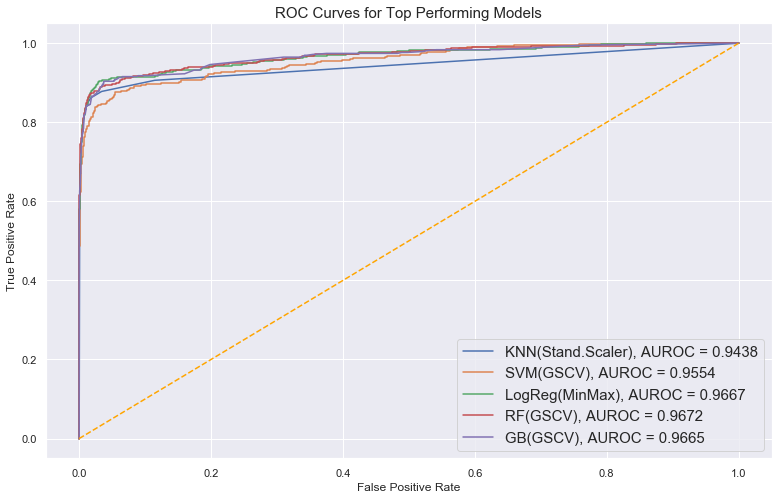

In [112]:
top_clf_info = zip(top_clf_names, top_clf_models, top_clf_test_sets, top_clf_aurocs, top_clf_pr_aucs)

roc_plot_func(top_clf_info, 'Top Performing Models')

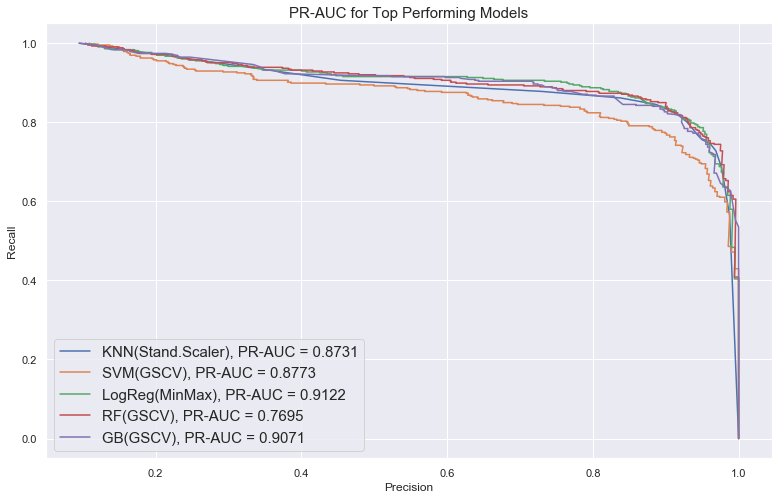

In [113]:
top_clf_info = zip(top_clf_names, top_clf_models, top_clf_test_sets, top_clf_aurocs, top_clf_pr_aucs)

pr_plot_func(top_clf_info, "Top Performing Models")

<Figure size 936x576 with 0 Axes>

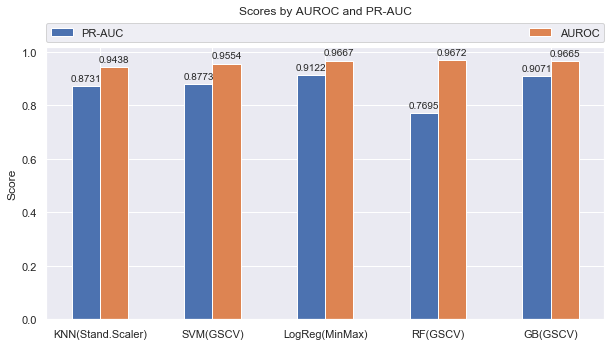

In [137]:
top_clf_pr_aucs_rounded = [round(x, 4) for x in top_clf_pr_aucs]
top_clf_aurocs_rounded = [round(x, 4) for x in top_clf_aurocs]
           
bar_chart_func(top_clf_names, top_clf_pr_aucs_rounded, top_clf_aurocs_rounded)